<a href="https://colab.research.google.com/github/mohamedshouaib/iti/blob/main/Computer_Vision/Day01/siamesenetwork_faceverification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/mohamedshouaib/iti.git
!cd iti/Computer_Vision/Day01/Siamese

Cloning into 'iti'...
remote: Enumerating objects: 638, done.
remote: Counting objects: 100% (423/423), done.
remote: Compressing objects: 100% (414/414), done.
remote: Total 638 (delta 73), reused 0 (delta 0), pack-reused 215 (from 1)
Receiving objects: 100% (638/638), 26.68 MiB | 8.30 MiB/s, done.
Resolving deltas: 100% (145/145), done.
Updating files: 100% (294/294), done.


In [90]:
import os
import cv2
import csv
import time
import random
import numpy as np
from google.colab.patches import cv2_imshow
from itertools import combinations
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras import layers, models, backend as K


import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__, np.__version__

('2.18.0', '2.0.2')

In [71]:
def load_dataset(base_path="iti/Computer_Vision/Day01/Siamese"):
    data = {'train': {}, 'test': {}}

    for person in os.listdir(base_path):
        person_path = os.path.join(base_path, person)
        if not os.path.isdir(person_path):
            continue

        for split in ['Train', 'Test']:
            split_path = os.path.join(person_path, split)
            if not os.path.exists(split_path):
                print(f"Missing {split} folder for {person}")
                continue

            # Find ANY CSV file
            csv_files = [f for f in os.listdir(split_path) if f.endswith('.csv')]
            if not csv_files:
                print(f"No CSV found in {split_path}")
                continue

            csv_path = os.path.join(split_path, csv_files[0])

            genuine = []
            forged = []

            with open(csv_path, 'r') as f:
                # Try different delimiters and column names
                try:
                    reader = csv.DictReader(f)
                    row = next(reader)  # Peek first row

                    # Detect column names
                    img_col = None
                    label_col = None

                    for col in row.keys():
                        col_lower = col.lower()
                        if 'image' in col_lower or 'name' in col_lower:
                            img_col = col
                        elif 'label' in col_lower or 'class' in col_lower:
                            label_col = col

                    if not img_col or not label_col:
                        raise ValueError("Couldn't detect required columns")

                    # Reset reader
                    f.seek(0)
                    next(reader)  # Skip header

                    for row in reader:
                        img_name = row[img_col].strip()
                        img_path = os.path.join(split_path, img_name)

                        if not os.path.exists(img_path):
                            print(f"Missing image: {img_path}")
                            continue

                        label = row[label_col].strip().lower()
                        if label == 'real' or label == 'genuine':
                            genuine.append(img_path)
                        elif label == 'forged' or label == 'fake':
                            forged.append(img_path)

                except Exception as e:
                    print(f"Error reading {csv_path}: {str(e)}")
                    continue

            if genuine or forged:  # Only add if we found data
                data[split.lower()][person] = {
                    'genuine': genuine,
                    'forged': forged
                }

    return data['train'], data['test']

# Test with debug info
print("Checking folder structure...")
base_path = "iti/Computer_Vision/Day01/Siamese"
print(f"Root contents: {os.listdir(base_path)}")
sample_person = os.listdir(base_path)[0]
print(f"Sample person contents: {os.listdir(os.path.join(base_path, sample_person))}")

train_data, test_data = load_dataset(base_path)

print("\nLoaded successfully!")
print(f"Persons in train: {list(train_data.keys())}")
print(f"Persons in test: {list(test_data.keys())}")

Checking folder structure...
Root contents: ['personA', 'personD', 'personB', 'personC', 'personE']
Sample person contents: ['Train', 'Test']

Loaded successfully!
Persons in train: ['personA', 'personD', 'personB', 'personC', 'personE']
Persons in test: ['personA', 'personD', 'personB', 'personC', 'personE']


In [91]:
def generate_triplets(data_dict, split='train'):
    triplets = []
    persons = list(data_dict[split].keys())

    for person in persons:
        genuine = data_dict[split][person]['genuine']
        forged = data_dict[split][person]['forged']

        # Generate all possible genuine pairs (anchor, positive)
        for i in range(len(genuine)):
            for j in range(i+1, len(genuine)):
                anchor = genuine[i]
                positive = genuine[j]

                # Pair with ALL forged signatures
                for neg in forged:
                    triplets.append((anchor, positive, neg))

                # # Also pair with genuine from DIFFERENT person (optional)
                # other_persons = [p for p in persons if p != person]
                # if other_persons:
                #     other_person = random.choice(other_persons)
                #     other_genuine = data_dict[split][other_person]['genuine']
                #     if other_genuine:
                #         triplets.append((anchor, positive, random.choice(other_genuine)))

    return triplets

In [92]:
# Generate triplets
train_triplets = generate_triplets({'train': train_data, 'test': test_data}, split='train')
test_triplets = generate_triplets({'train': train_data, 'test': test_data}, split='test')

In [93]:
# Check the actual dimensions of your images
sample_path = train_triplets[0][0]  # First anchor path
sample_img = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)
true_height, true_width = sample_img.shape
print(f"Actual image dimensions: {true_height}x{true_width}")

# Update your input shape
input_shape = (true_height, true_width, 1)

Actual image dimensions: 312x342


In [94]:
def load_triplet_images(triplet, img_size=(150, 150)):
    def load_image(path):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Failed to load image: {path}")
        img = cv2.resize(img, img_size)
        return img.astype(np.float32) / 255.0  # Normalize to [0,1]

    anchor = load_image(triplet[0])
    positive = load_image(triplet[1])
    negative = load_image(triplet[2])

    return anchor, positive, negative

In [95]:
# Usage Example
train_data, test_data = load_dataset("iti/Computer_Vision/Day01/Siamese")

In [96]:
def show_triplet(triplet):
    try:
        anchor, positive, negative = load_triplet_images(triplet)

        # Convert to 8-bit for display (if normalized to [0,1])
        if anchor.max() <= 1.0:
            anchor = (anchor * 255).astype(np.uint8)
            positive = (positive * 255).astype(np.uint8)
            negative = (negative * 255).astype(np.uint8)

        # Create a combined display image
        h, w = anchor.shape
        separator = np.ones((h, 5), dtype=np.uint8) * 255  # White separator
        combined = np.hstack([anchor, separator, positive, separator, negative])

        # Add labels
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(combined, 'Anchor', (5, 20), font, 0.5, 255, 1)
        cv2.putText(combined, 'Positive', (w+10, 20), font, 0.5, 255, 1)
        cv2.putText(combined, 'Negative', (2*w+15, 20), font, 0.5, 255, 1)

        # Display (use cv2_imshow in Colab, cv2.imshow otherwise)
        try:
            from google.colab.patches import cv2_imshow
            cv2_imshow(combined)
        except:
            cv2.imshow('Triplet', combined)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

    except Exception as e:
        print(f"Error displaying triplet: {e}")
        print(f"Triplet paths: {triplet}")

Generated 19000 train triplets
Generated 120 test triplets


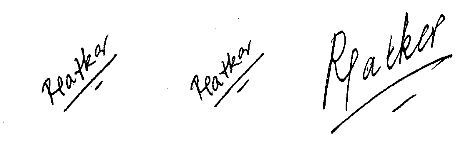

In [97]:
print(f"Generated {len(train_triplets)} train triplets")
print(f"Generated {len(test_triplets)} test triplets")
show_triplet(train_triplets[0])  # Display first training triplet

In [98]:
# 1. Embedding Network Architecture
def create_embedding_network(input_shape):
    """Creates the shared weights network for signature embeddings"""
    model = models.Sequential([
        # Convolutional Base
        layers.Conv2D(32, (5,5), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.BatchNormalization(),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.BatchNormalization(),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.BatchNormalization(),

        # Dense Head
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation=None),  # No activation for embedding space
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))  # L2 normalize embeddings
    ])
    return model

In [99]:
# 2. Triplet Loss Function
class TripletLoss(layers.Layer):
    def __init__(self, margin=0.2, **kwargs):
        super().__init__(**kwargs)
        self.margin = margin

    def call(self, inputs):
        anchor, positive, negative = inputs
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
        return tf.maximum(pos_dist - neg_dist + self.margin, 0.0)

    def get_config(self):
        return {'margin': self.margin}

In [100]:
# 3. Data Generator (Optimized Version)
class SignatureTripletGenerator(tf.keras.utils.Sequence):
    def __init__(self, triplets, batch_size=32, img_size=(150,150), augment=False):
        self.triplets = triplets
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.triplets) / self.batch_size))

    def __getitem__(self, idx):
        batch = self.triplets[idx*self.batch_size : (idx+1)*self.batch_size]

        anchors = np.zeros((len(batch), *self.img_size, 1))
        positives = np.zeros((len(batch), *self.img_size, 1))
        negatives = np.zeros((len(batch), *self.img_size, 1))

        for i, (a_path, p_path, n_path) in enumerate(batch):
            # Load images with error handling
            anchors[i] = self._load_image(a_path)
            positives[i] = self._load_image(p_path)
            negatives[i] = self._load_image(n_path)

        return [anchors, positives, negatives], np.zeros(len(batch))

    def _load_image(self, path):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Failed to load image: {path}")

        # Resize to target dimensions
        img = cv2.resize(img, self.img_size)

        # Data augmentation
        if self.augment and np.random.rand() > 0.5:
            img = cv2.flip(img, 1)  # Horizontal flip
            if np.random.rand() > 0.5:
                angle = np.random.uniform(-10, 10)
                M = cv2.getRotationMatrix2D((self.img_size[0]//2, self.img_size[1]//2), angle, 1)
                img = cv2.warpAffine(img, M, self.img_size)

        return np.expand_dims(img, axis=-1) / 255.0  # Add channel and normalize

    def on_epoch_end(self):
        """Shuffle triplets after each epoch"""
        np.random.shuffle(self.triplets)

In [101]:
# 4. Complete Siamese Model
def build_siamese_model(input_shape):
    # Input layers
    anchor_input = layers.Input(input_shape, name='anchor_input')
    positive_input = layers.Input(input_shape, name='positive_input')
    negative_input = layers.Input(input_shape, name='negative_input')

    # Shared embedding network
    embedding_network = create_embedding_network(input_shape)

    # Generate embeddings
    anchor_embedding = embedding_network(anchor_input)
    positive_embedding = embedding_network(positive_input)
    negative_embedding = embedding_network(negative_input)

    # Calculate triplet loss
    loss_layer = TripletLoss(margin=0.2, name='triplet_loss')
    loss = loss_layer([anchor_embedding, positive_embedding, negative_embedding])

    # Connect inputs and outputs
    model = models.Model(
        inputs=[anchor_input, positive_input, negative_input],
        outputs=loss
    )

    return model, embedding_network

In [102]:
# 5. Model Training Setup
# Get actual image dimensions from your data
input_shape = (true_height, true_width, 1)

# Build model
siamese_model, embedding_model = build_siamese_model(input_shape)

# Custom compile with dummy optimizer (loss is computed in model)
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(0.0001))

# Create data generators
train_generator = SignatureTripletGenerator(
    train_triplets,
    batch_size=32,
    img_size=(true_width, true_height),  # OpenCV uses (width, height)
    augment=True
)

test_generator = SignatureTripletGenerator(
    test_triplets,
    batch_size=32,
    img_size=(true_width, true_height)
)

In [103]:
# 6. Training Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(
        'siamese_best.h5',
        save_best_only=True,
        save_weights_only=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
]

ValueError: When using `save_weights_only=True` in `ModelCheckpoint`, the filepath provided must end in `.weights.h5` (Keras weights format). Received: filepath=siamese_best.h5

In [87]:
# 7. Train the Model
history = siamese_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=50,
    callbacks=callbacks
)

In [88]:
# 8. Save the Embedding Model
embedding_model.save('signature_embedder.h5')

In [ ]:
def verify_signatures(anchor_path, test_path, threshold=0.5):
    # Load models
    embedding_model = tf.keras.models.load_model('signature_embedding.h5')

    # Preprocess images
    def preprocess(path):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (150, 150)).reshape(1, 150, 150, 1)/255.0
        return img

    # Get embeddings
    anchor_embed = embedding_model.predict(preprocess(anchor_path))
    test_embed = embedding_model.predict(preprocess(test_path))

    # Calculate distance
    distance = np.sum(np.square(anchor_embed - test_embed))

    # Verification decision
    return distance < threshold, distance

# Example usage
is_genuine, dist = verify_signatures(
    anchor_path="path/to/genuine_sample.png",
    test_path="path/to/test_sample.png"
)
print(f"Genuine: {is_genuine} (Distance: {dist:.4f})")